LOAD THE DATASET

In [ ]:
from pathlib import Path
import polars as pl

BASE = Path.home() / "creditrisk-llm"           
PROC = BASE / "data" / "processed"
PARQ = PROC / "cfpb.parquet"

print("🔍 Looking for:", PARQ)
if not PARQ.exists():
    raise FileNotFoundError("cfpb.parquet not found — run data_ingestion.py first.")

cfpb = pl.read_parquet(PARQ)

print(f"\n Loaded: {cfpb.height:,} rows  |  {cfpb.width} columns")
print("First 10 column names:")
print(cfpb.columns[:10])

cfpb.head(3)

🔍 Looking for: /Users/prekshashah/creditrisk-llm/data/processed/cfpb.parquet

 Loaded: 9,420,854 rows  |  18 columns
First 10 column names:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code']


Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
"""2025-06-09""","""Credit reporting or other pers…","""Credit reporting""","""Incorrect information on your …","""Information belongs to someone…",null,null,"""EQUIFAX, INC.""","""NC""","""27613""",null,null,"""Web""","""2025-06-09""","""In progress""","""Yes""","""N/A""",13964976
"""2025-06-09""","""Credit reporting or other pers…","""Credit reporting""","""Incorrect information on your …","""Information belongs to someone…",null,null,"""EQUIFAX, INC.""","""TX""","""77306""",null,null,"""Web""","""2025-06-09""","""In progress""","""Yes""","""N/A""",13964977
"""2025-06-09""","""Credit reporting or other pers…","""Credit reporting""","""Problem with a company's inves…","""Their investigation did not fi…",null,null,"""EQUIFAX, INC.""","""FL""","""34116""",null,null,"""Web""","""2025-06-09""","""In progress""","""Yes""","""N/A""",13964981


Identify the narrative column & measure coverage / length

In [2]:
import polars as pl
import re

# Locate any column whose name contains “narrative”
narr_cols = [c for c in cfpb.columns if re.search(r"narrative", c, flags=re.I)]
print("Columns containing 'narrative':", narr_cols)
if not narr_cols:
    raise ValueError("🛑  No narrative column found!")

# Rename the chosen column → 'narrative' for convenience
TEXT_COL_ORIG = narr_cols[0]
cfpb = cfpb.rename({TEXT_COL_ORIG: "narrative"})
TEXT_COL = "narrative"

# Build a reusable length expression
try:
    length_expr = pl.col(TEXT_COL).str.len_bytes()       # Polars ≥ 0.20
except AttributeError:
    length_expr = pl.col(TEXT_COL).str.lengths()         # Polars ≤ 0.19.x

# Filter rows that actually contain text
with_text = cfpb.filter(
    pl.col(TEXT_COL).is_not_null() & (length_expr > 0)
)
n_text, n_total = with_text.height, cfpb.height
pct_text = round(100 * n_text / n_total, 2)

print(f"\nTotal rows:           {n_total:,}")
print(f"Rows with narratives: {n_text:,}  ({pct_text} %)")

# Character-length summary
length_stats = (
    with_text
    .with_columns(length_expr.alias("char_len"))
    .select("char_len")
    .describe()
)
print("\nNarrative length summary (characters):")
print(length_stats)

print("\nSample snippets:")
for i, txt in enumerate(with_text[TEXT_COL].head(3), 1):
    print(f"{i}. {txt[:200]}…\n")

Columns containing 'narrative': ['Consumer complaint narrative']

Total rows:           9,420,854
Rows with narratives: 2,938,055  (31.19 %)

Narrative length summary (characters):
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ char_len    │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 2.938055e6  │
│ null_count ┆ 0.0         │
│ mean       ┆ 1000.262458 │
│ std        ┆ 1301.931798 │
│ min        ┆ 4.0         │
│ 25%        ┆ 334.0       │
│ 50%        ┆ 659.0       │
│ 75%        ┆ 1189.0      │
│ max        ┆ 32962.0     │
└────────────┴─────────────┘

Sample snippets:
1. In accordance with the Fair Credit Reporting act, the list of accounts below has violated my federally protected consumer rights to privacy and confidentiality under 15 USC 1681.

The accounts below h…

2. The Fair Credit Reporting Act ( 15 U.S. Code 1681 ) says ( 1 ) The banking system is dependent upon fair and accurate credit reporting. Inaccur

Length-distribution plot + quick top-word snapshot

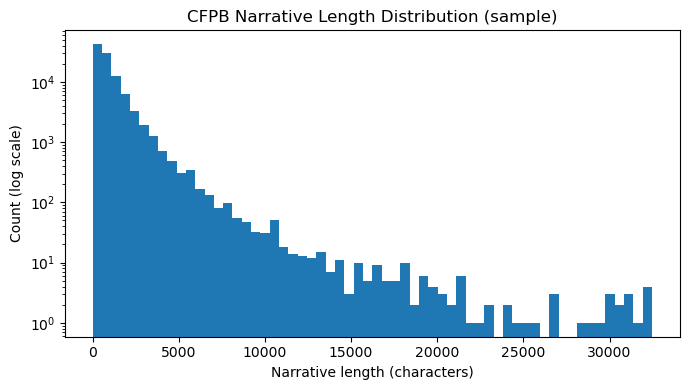


Top 25 tokens (after stop-word removal):
xxxx         1,302,406
xx           219,463
credit       193,096
account      140,283
report       118,347
information  116,419
consumer     93,894
reporting    88,580
00           66,518
15           58,961
accounts     55,263
payment      45,989
debt         42,128
section      39,723
did          32,576
agency       32,205
inaccurate   30,906
company      29,857
act          29,218
bank         28,985
date         28,451
late         28,429
number       28,360
card         28,018
received     27,835


In [3]:
import polars as pl
import random, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Work from the filtered DataFrame with_text we built above
SAMPLE_SIZE = 100_000                   
sample_df = with_text.sample(n=min(SAMPLE_SIZE, with_text.height), seed=42)

# Length histogram (characters)
lens = sample_df.with_columns(
    pl.col("narrative").str.len_bytes().alias("char_len")
)["char_len"]

plt.figure(figsize=(7,4))
plt.hist(lens.to_list(), bins=60, log=True)         
plt.xlabel("Narrative length (characters)")
plt.ylabel("Count (log scale)")
plt.title("CFPB Narrative Length Distribution (sample)")
plt.tight_layout()
plt.show()

# Quick top-token snapshot
vectorizer = CountVectorizer(stop_words="english",
                             max_features=25,        # top-25 words
                             token_pattern=r"(?u)\b\w\w+\b")   # ≥2-letter tokens
X   = vectorizer.fit_transform(sample_df["narrative"].to_list())
totals = X.sum(axis=0).A1
top_tokens = sorted(zip(vectorizer.get_feature_names_out(), totals),
                    key=lambda t: t[1], reverse=True)

print("\nTop 25 tokens (after stop-word removal):")
for word, count in top_tokens:
    print(f"{word:<12} {count:,}")



Basic cleaning

In [5]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import polars as pl

def clean_text(series: pl.Series) -> list[str]:
    """
    lightweight cleaning for CFPB complaint narratives.
      - lower-case
      - drop 'x', 'xx', 'xxxx' placeholders
      - strip digits / punctuation (keep a–z)
      - collapse multiple spaces
    Returns plain Python list[str] suitable for scikit-learn.
    """
    patt_x    = re.compile(r"\b[x]+\b", flags=re.I)      # redact placeholders
    patt_nond = re.compile(r"[^a-z\s]+")                 # non-letters
    cleaned = []
    for s in series:
        if s is None:
            cleaned.append("")
            continue
        s = s.lower()
        s = patt_x.sub(" ", s)
        s = patt_nond.sub(" ", s)
        s = " ".join(s.split())                         
        cleaned.append(s)
    return cleaned

# Sample up to 100 k narratives 
SAMPLE_SIZE = 100_000
sample_series = with_text.sample(n=min(SAMPLE_SIZE, with_text.height),
                                 seed=123)["narrative"]
cleaned_texts = clean_text(sample_series)

#  Top-25 tokens after cleaning
vectorizer = CountVectorizer(stop_words="english",
                             max_features=25,
                             token_pattern=r"(?u)\b[a-z]{2,}\b")
X = vectorizer.fit_transform(cleaned_texts)
totals = X.sum(axis=0).A1
top_tokens = sorted(zip(vectorizer.get_feature_names_out(), totals),
                    key=lambda t: t[1], reverse=True)

print("Top 25 tokens AFTER cleaning placeholders & digits:")
for word, cnt in top_tokens:
    print(f"{word:<12} {cnt:,}")


Top 25 tokens AFTER cleaning placeholders & digits:
credit       193,736
account      140,907
report       119,793
information  117,850
consumer     94,781
reporting    90,778
accounts     55,596
payment      45,799
debt         42,197
section      40,469
agency       33,178
did          32,321
inaccurate   32,001
act          30,224
company      29,575
number       28,653
late         28,585
bank         28,491
date         28,476
received     27,970
days         27,877
balance      27,813
card         27,266
dispute      26,641
time         26,582


Embedding preview

⏳  Loading all-MiniLM-L6-v2 on mps …


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

⏳  Running t-SNE …
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.002s...


/opt/anaconda3/envs/creditrisk/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 25000 samples in 1.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sample 13000 / 25000
[t-SNE] Computed conditional probabilities for sample 14000 / 25000

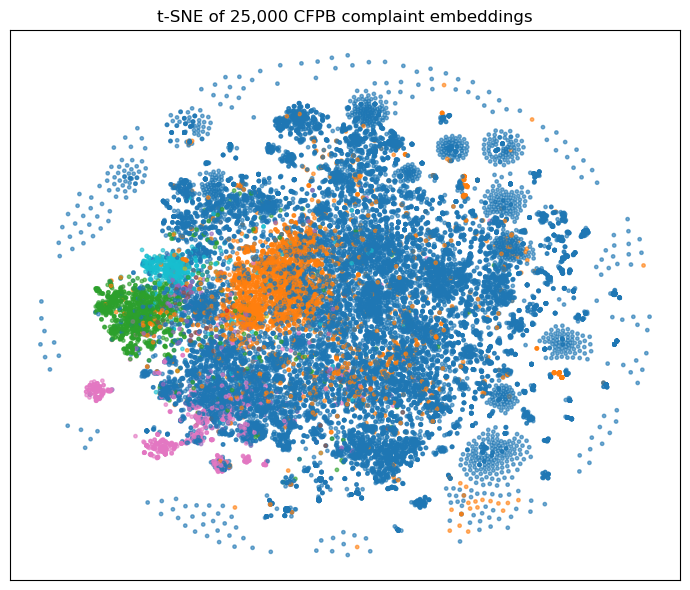

In [6]:
import random, torch, numpy as np, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

SAMPLE_SIZE = 25_000         
SEED        = 42

# Sample & clean narratives (re-using clean_text generated above
sample_df = with_text.sample(n=min(SAMPLE_SIZE, with_text.height), seed=SEED)
texts     = clean_text(sample_df["narrative"])        
labels    = sample_df["Product"]                       

# Load SentenceTransformer model  
device = (
    "mps"  if torch.backends.mps.is_available() else     # Apple-silicon GPU
    "cuda" if torch.cuda.is_available()        else
    "cpu"
)
print(f"⏳  Loading all-MiniLM-L6-v2 on {device} …")
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Encode texts into 384-dim embeddings 
embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
    device=device,
)

# Reduce to 2-D with t-SNE 
print("⏳  Running t-SNE …")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=1_000,
    random_state=SEED,
    verbose=1,
)
coords = tsne.fit_transform(embeddings)

# Plot scatter, coloured by Product 
unique_prods = labels.unique().to_list()
palette      = {p: i for i, p in enumerate(unique_prods[:10])}
colours      = [palette.get(p, 0) for p in labels]

plt.figure(figsize=(7, 6))
plt.scatter(coords[:, 0], coords[:, 1],
            s=6, alpha=0.6, c=colours, cmap="tab10")   
plt.title(f"t-SNE of {len(texts):,} CFPB complaint embeddings")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


Sentiment Snapshot

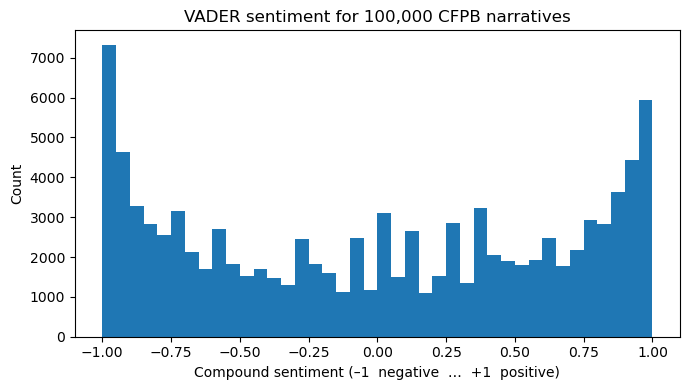


Percentiles of compound score:
 5th : -0.969
25th : -0.670
50th :  0.000
75th :  0.631
95th :  0.960


In [7]:
import nltk, matplotlib.pyplot as plt, numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon once
nltk.download("vader_lexicon", quiet=True)

# Sample & clean 
SAMPLE_SIZE = 100_000
sample_df   = with_text.sample(n=min(SAMPLE_SIZE, with_text.height), seed=2025)
cleaned_txt = clean_text(sample_df["narrative"])          

# Run VADER on each complaint
sia = SentimentIntensityAnalyzer()
scores = np.array([sia.polarity_scores(t)["compound"] for t in cleaned_txt])

# Plot sentiment distribution
plt.figure(figsize=(7,4))
plt.hist(scores, bins=40)                
plt.xlabel("Compound sentiment (–1  negative  …  +1  positive)")
plt.ylabel("Count")
plt.title(f"VADER sentiment for {len(scores):,} CFPB narratives")
plt.tight_layout()
plt.show()

# Print key percentiles
print("\nPercentiles of compound score:")
for p in (5, 25, 50, 75, 95):
    print(f"{p:>2}th : {np.percentile(scores, p): .3f}")